In [ ]:
!pip install --pre torch
!pip install xformers pytorch_lightning numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [7]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [8]:
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import cv2
from io import BytesIO
from skimage import io
from math import e
from skimage.metrics import structural_similarity as ssim
from skimage.color import gray2rgb, gray2rgba
from tabulate import tabulate
# import lpips

from diffusers import LEditsPPPipelineStableDiffusion
from diffusers import StableDiffusionInstructPix2PixPipeline
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers.utils import load_image

from PIL import Image
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings("ignore")

# Prompts to use for text guided image to image generation:

- ecofab images: a set of roots - can you make one of the roots to grow downward?
- Empty-Fe-Sand-10x_500.tif: a cross-section of a rock sample - can you create the adjacent slices?
- cmc.tif: a cross section of a composite material - can you deform the circles?


(np.float64(-0.5), np.float64(2559.5), np.float64(2559.5), np.float64(-0.5))

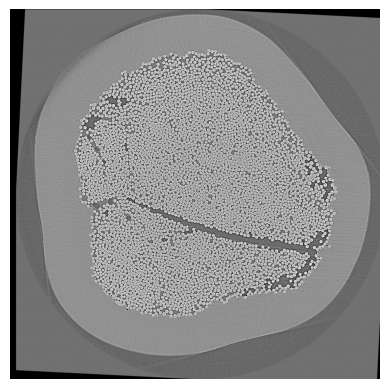

In [ ]:
dataroot = "/content/drive/MyDrive/CAMERA Stable Diffusion/data/cmc.tif"

composite_img = io.imread(dataroot)
plt.imshow(composite_img, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

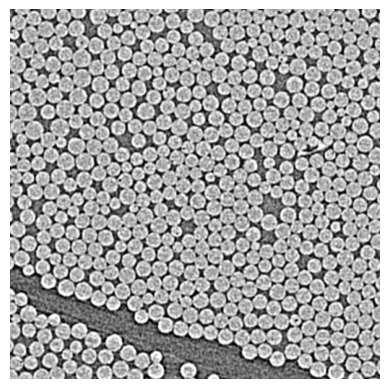

In [9]:
# Create a cropped version of the full size image
composite_img = io.imread("/content/drive/MyDrive/CAMERA Stable Diffusion/data/cmc_cropped_512.png")
transform = transforms.Compose([
    transforms.CenterCrop((512, 512))
])

cropped_img = transform(Image.fromarray(composite_img))
plt.imshow(cropped_img, cmap='gray')
plt.axis('off')
# cropped_img.save("/content/drive/MyDrive/CAMERA Stable Diffusion/data/cmc_cropped_512.png")

# ControlNET on '*artistic'* image

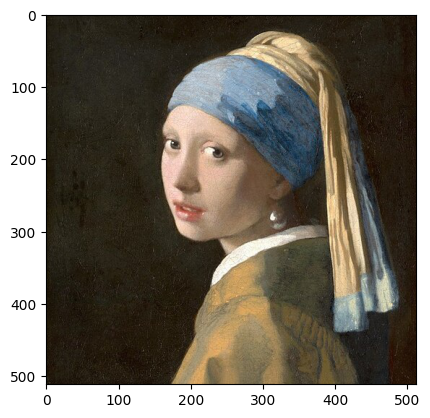

In [ ]:
# Download an image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image = np.array(image)
plt.imshow(image)

In [ ]:
print(image.shape)

(512, 512, 3)


In [ ]:
%%time
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

# Load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

# Speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# Generate image
prompt = "a portrait of a women with long dark hair and blue eyes"
generator = torch.manual_seed(0)
gen_image = pipe(prompt, num_inference_steps=20, generator=generator, image=canny_image
).images[0]

import time
time.sleep(2)
print("Done!")

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Done!
CPU times: user 17 s, sys: 14.6 s, total: 31.6 s
Wall time: 1min 5s


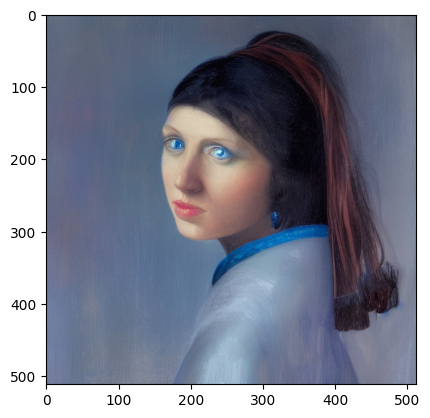

In [ ]:
plt.imshow(gen_image)

## ControlNET on CMC Fiber Bed microCT image

In [4]:
# Code to be timed
rgb_img = gray2rgb(cropped_img) # Convert to RGB image

image = cv2.Canny(rgb_img, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
lst_imgs = []
prompt = "a cross section of a composite material with deformed circles"
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(0)

n = 5 # Number of samples to generate
for i in range (n):
  gen_image = pipe(prompt, num_inference_steps=30+i, generator=generator, image=canny_image).images[0]
  lst_imgs.append(gen_image)
  # gen_image.save("/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/controlNET_cmc_{}.png".format(i))


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

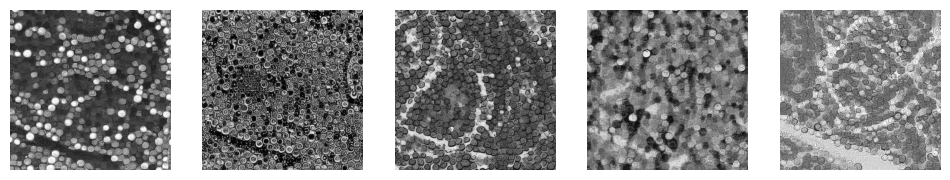

In [10]:
from skimage.color import rgb2gray
fig ,ax = plt.subplots(1, 5, figsize=(12, 6))
for i in range(5):
  ax[i].imshow(rgb2gray(np.array(lst_imgs[i])), cmap='gray')
  ax[i].axis('off')


# Stable unCLIP on *'artistic'* image


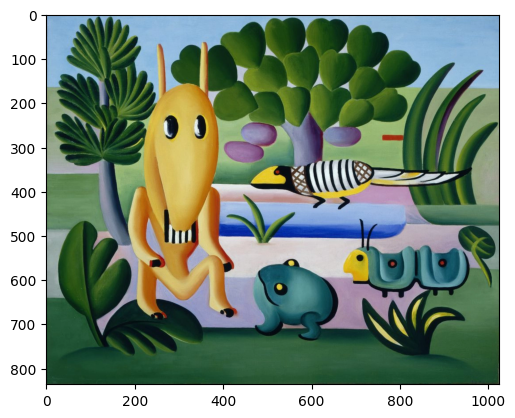

In [ ]:
url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/stable_unclip/tarsila_do_amaral.png"
init_image = load_image(url)
plt.imshow(init_image)

In [ ]:
init_image.size

(1024, 836)

In [ ]:
drawing_img = transform(init_image)

%%time
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, variation="fp16"
)
pipe = pipe.to("cuda")
# If adding a prompt:
prompt = "A fantasy landscape, trending on artstation"
image = pipe(drawing_img, prompt=prompt).images[0]

time.sleep(2)
print("Done")

(836, 1024, 3)
(512, 512, 3)


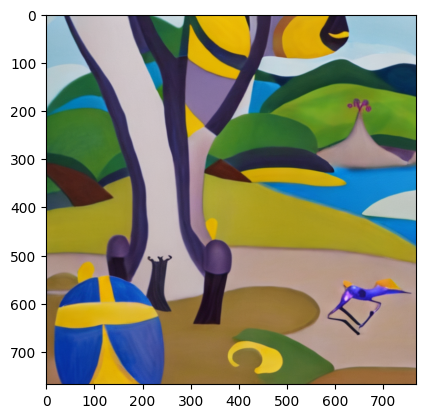

In [ ]:
plt.imshow(image)

# Stable unCLIP on CMC

In [11]:
lst_imgs = []
prompt = "a cross section of a composite material with deformed circles"
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
clip_text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")

tokenized_prompt_clip = clip_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
prompt_embeds_clip = clip_text_encoder(tokenized_prompt_clip)[0]

pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, variation="fp16"
)
pipe = pipe.to("cuda")
image = Image.fromarray(rgb_img)

n = 5 # Number of samples to generate
for i in range(n):
  image = pipe(image, prompt).images[0]
  lst_imgs.append(image)
  # image.save("/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/stableunCLIP_cmc_{}.png".format(i))

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.53G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.48G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

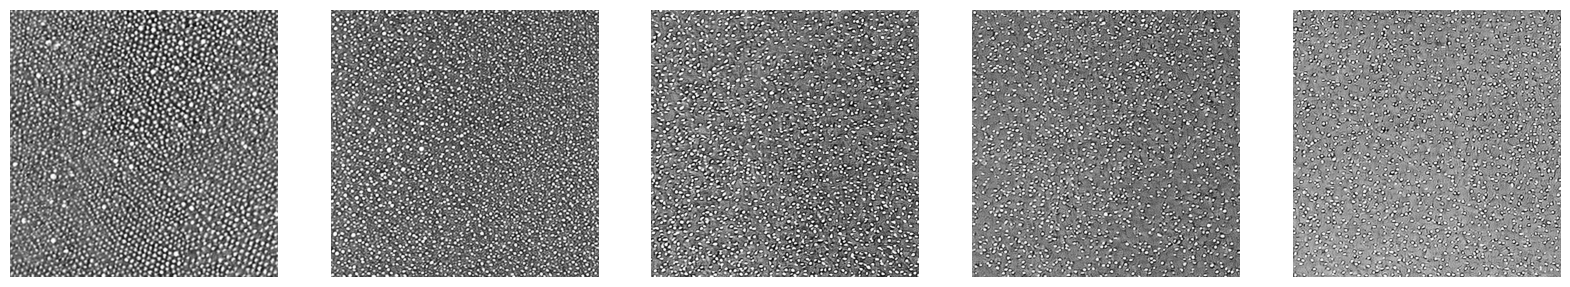

In [14]:

fig ,ax = plt.subplots(1, 5, figsize=(20, 6))
for i in range(5):
  ax[i].imshow(rgb2gray(np.array(lst_imgs[i])), cmap='gray')
  ax[i].axis('off')

# DiffEdit on original example *'the fruit bowl'*

In [15]:
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://github.com/Xiang-cd/DiffEdit-stable-diffusion/raw/main/assets/origin.png"
init_image = download_image(img_url).resize((768, 768))

pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16
)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()

mask_prompt = "A bowl of fruits"
prompt = "A bowl of pears"

mask_image = pipeline.generate_mask(image=init_image, source_prompt=prompt, target_prompt=mask_prompt)
image_latents = pipeline.invert(image=init_image, prompt=mask_prompt).latents
image = pipeline(prompt=prompt, mask_image=mask_image, image_latents=image_latents).images[0]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

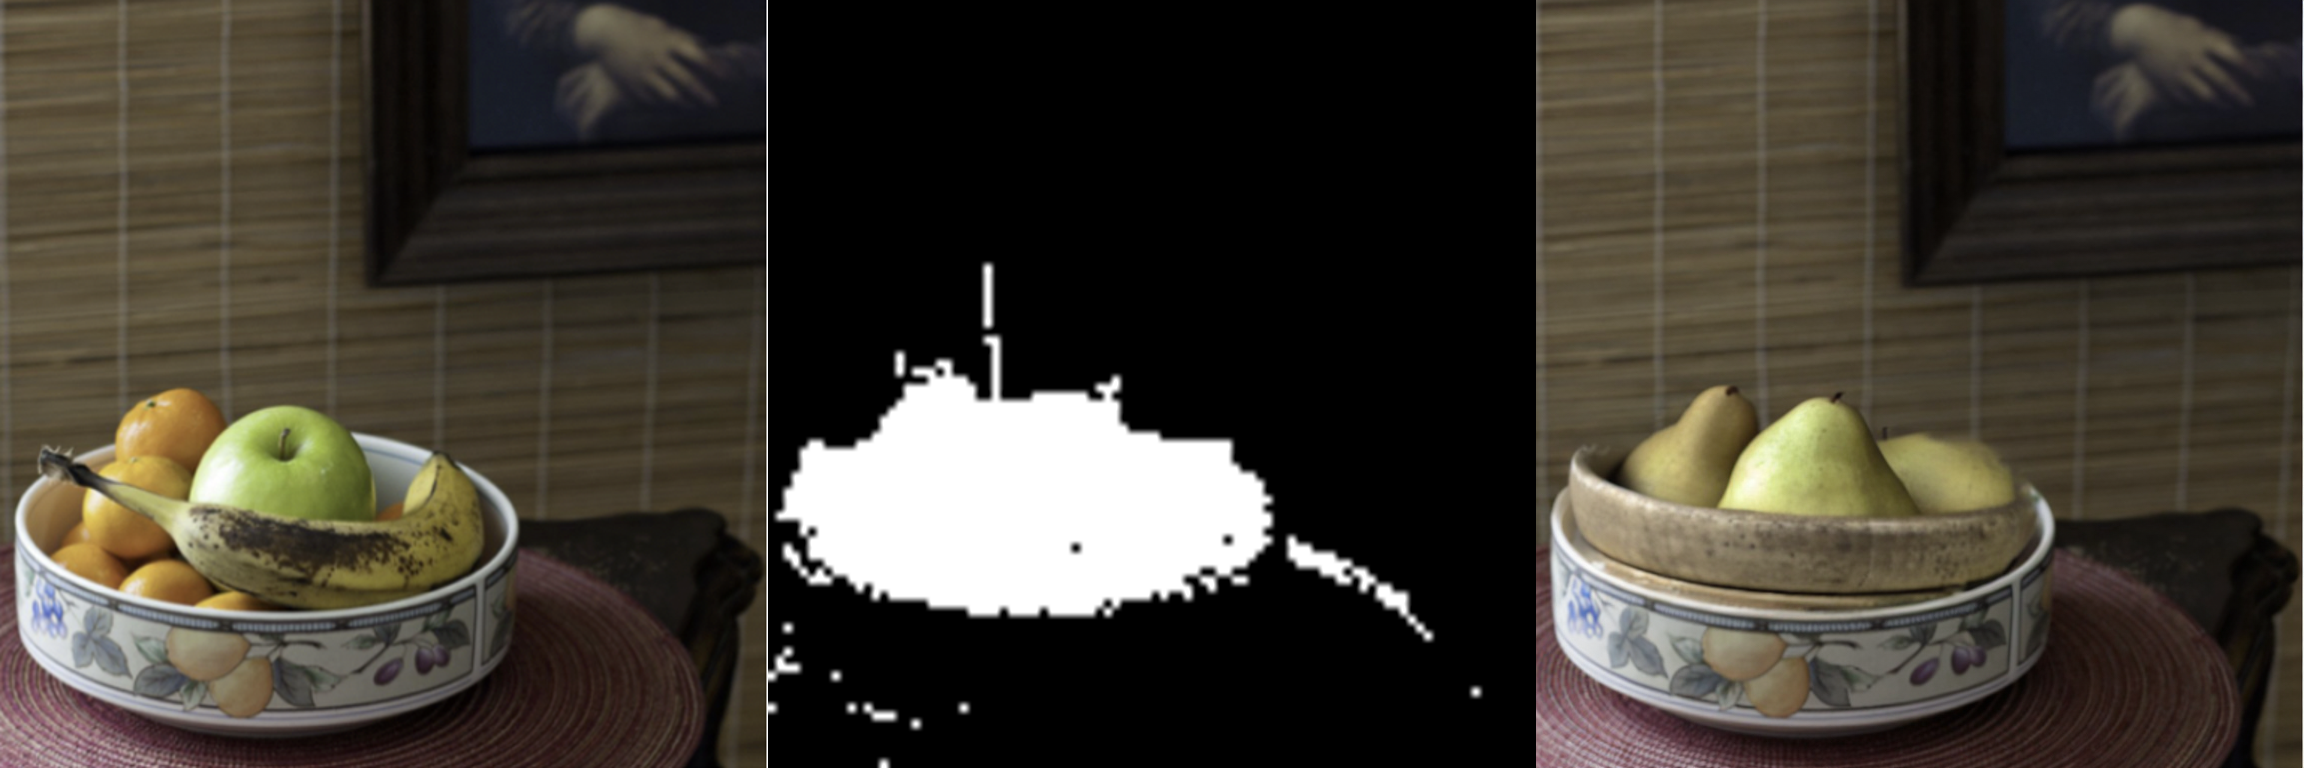

In [16]:
from diffusers.utils import load_image, make_image_grid
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))
make_image_grid([init_image, mask_image, image], rows=1, cols=3)

# DiffEdit on CMC

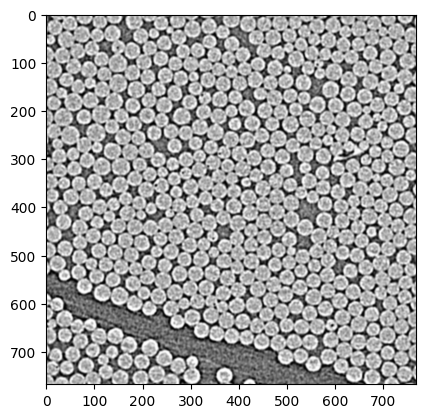

In [4]:
composite_img = io.imread("/content/drive/MyDrive/CAMERA Stable Diffusion/data/cmc_cropped_512.png")
init_image = Image.fromarray(composite_img).convert('RGB').resize((768, 768))
plt.imshow(Image.fromarray(composite_img).convert('RGB').resize((768, 768)))

In [5]:
%%time
n = 5 # Number of samples to generate
pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
      "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()
mask_prompt = "small bubbles"
prompt = "large bubbles"
lst_imgs_diffedit = []
lst_masks_diffedit = []
for i in range(n):
  mask_image = pipeline.generate_mask(image=init_image, source_prompt=prompt, target_prompt=mask_prompt)
  image_latents = pipeline.invert(image=init_image, prompt=mask_prompt).latents
  image = pipeline(prompt=prompt, mask_image=mask_image, image_latents=image_latents).images[0]
  lst_imgs_diffedit.append(image)
  lst_masks_diffedit.append(mask_image)
  # image.save("/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/diffedit_cmc_{}.png".format(i))


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 3min 24s, sys: 25.9 s, total: 3min 50s
Wall time: 4min 56s


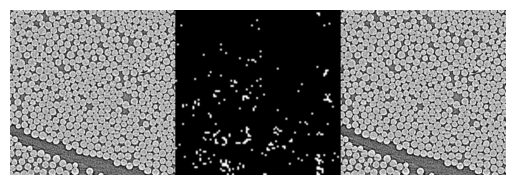

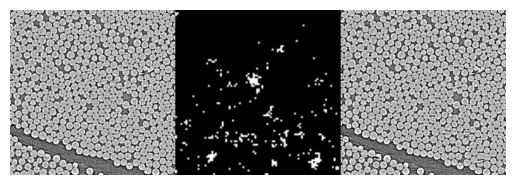

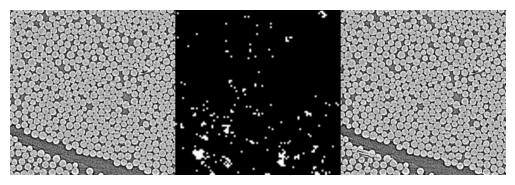

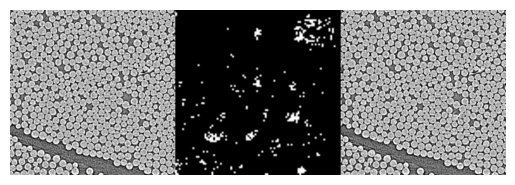

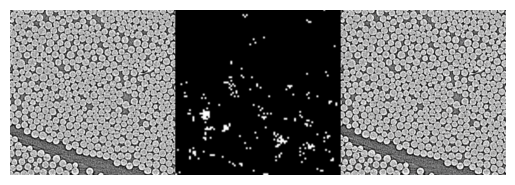

In [13]:
from diffusers.utils import load_image, make_image_grid

for i in range(n):
  mask_image = Image.fromarray((lst_masks_diffedit[i].squeeze()*255).astype("uint8"), "L").resize((768, 768))
  plt.imshow(make_image_grid([init_image, mask_image, lst_imgs_diffedit[i]], rows=1, cols=3))
  plt.axis('off')
  plt.show()


In [ ]:
image.save("/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/diffedit_cmc.png")

# LEDITS on *'cherry blossom'* image

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

This pipeline only supports DDIMScheduler and DPMSolverMultistepScheduler. The scheduler has been changed to DPMSolverMultistepScheduler.


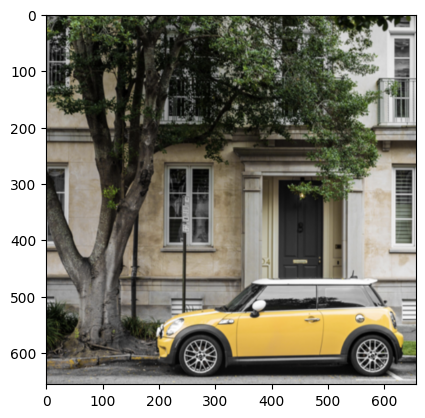

In [14]:
pipe = LEditsPPPipelineStableDiffusion.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")
img_url = "https://www.aiml.informatik.tu-darmstadt.de/people/mbrack/cherry_blossom.png"
car_image = load_image(img_url).convert("RGB")
plt.imshow(car_image)
plt.show()


# LEDITS on CMC data


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

This pipeline only supports DDIMScheduler and DPMSolverMultistepScheduler. The scheduler has been changed to DPMSolverMultistepScheduler.


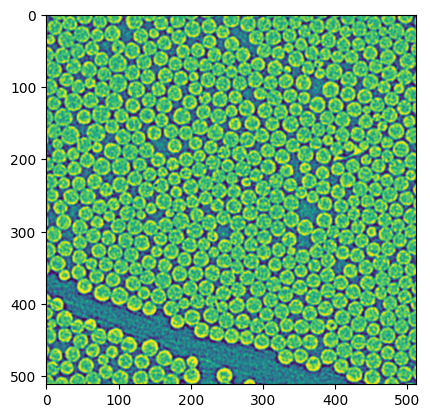

In [10]:
pipe = LEditsPPPipelineStableDiffusion.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

image = gray2rgb(cropped_img)
plt.imshow(cropped_img)
plt.show()


In [11]:
_ = pipe.invert(image=image, num_inversion_steps=10, skip=0.3)
n = 5 # Number of samples to generate
lst_imgs = []
for i in range(n):
  edited_image = pipe(
      editing_prompt=["small deformed circles"], edit_guidance_scale=20, edit_threshold=0.3).images[0]
  # edited_image.save("/content/drive/MyDrive/CAMERA Stable Diffusion/generated_samples/ledits_cmc_{}.png".format(i))
  lst_imgs.append(edited_image)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

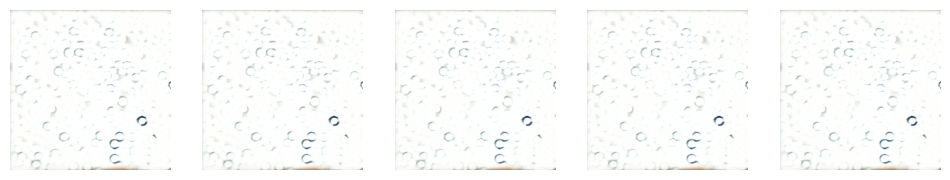

In [14]:
from skimage.color import rgb2gray
fig, ax = plt.subplots(1, 5, figsize=(12, 6))
for i in range(5):
  ax[i].imshow(np.array(lst_imgs[i]))
  # ax[i].imshow(rgb2gray(np.array(lst_imgs[i])), cmap='gray')
  ax[i].axis('off')

# InstructPix2Pix on *'mountain'* image

In [ ]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


img_url = "https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/mountain.png"

image = download_image(img_url).resize((512, 512))

pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

prompt = "make the mountains snowy"
image = pipe(prompt=prompt, image=image).images[0]

In [ ]:
plt.imshow(image)
plt.show()

# InstructPix2Pix on CMC image

In [ ]:
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

prompt = "make the mountains snowy"
image = pipe(prompt=prompt, image=image).images[0]